# Exploratory Data Analysis

## Imports

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys,os
notebook_path = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_root)

from utils.visuals import plot_numerical_distribution, plot_categorical_distribution, stacked_bar_churn_ratio, boxplot_by_churn, kdeplot_by_churn, countplot_with_churn

## Data

In [6]:
data = pd.read_csv('../data/cleaned_data.csv')
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,No,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,No,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151.65,1


## Feature Prioritization: Selecting Key Column for EDA

In [7]:
# isolate types
categorical_cols = data.select_dtypes(include='object').columns.tolist()
numerical_cols = data.select_dtypes(include='number').columns.tolist()

# Prioritize with feature importance
from sklearn.feature_selection import mutual_info_classif
X = data.drop(columns='Churn')
y = data['Churn']
dummy_df = pd.get_dummies(X)
importances = mutual_info_classif(dummy_df, y)
important_features = pd.Series(importances, index=dummy_df.columns).sort_values(ascending=False)

#Plot only the top 5
top_numerical = [col for col in important_features.index if col in data.columns and data[col].dtype != 'object'][:5]

dummy_to_original = {}
for col in dummy_df.columns:
    for orig_col in X.columns:
        if col.startswith(orig_col + '_'):
            dummy_to_original[col] = orig_col
            break
        elif col == orig_col:  
            dummy_to_original[col] = orig_col
            break

top_categorical = pd.Series(dummy_to_original.values(), index=dummy_to_original.keys())
top_categorical = top_categorical.loc[important_features.index]
top_categorical = top_categorical[top_categorical.isin(X.select_dtypes(include='object').columns)].unique()[:5].tolist()


In [8]:
print(f"selected numerical column: {top_numerical}")
print(f"selected categorical columns: {top_categorical}")

selected numerical column: ['tenure', 'MonthlyCharges', 'TotalCharges', 'PaperlessBilling', 'SeniorCitizen']
selected categorical columns: ['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity', 'TechSupport']


accordingly, we will perform univariate analysis on the above features

## Univariate Analysis

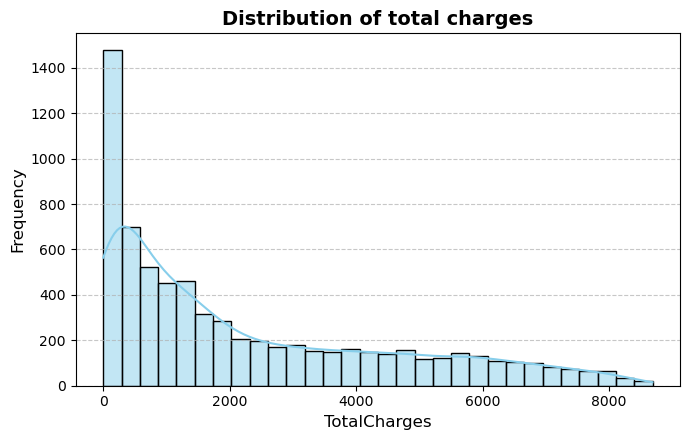

In [9]:
plot_numerical_distribution(data, 'TotalCharges', 'Distribution of total charges')

### Observation
- Highly Right-Skewed Distribution: most customers have **low total charges**
- High frequency of TotalCharges near 0 indicates that most of them are new or short-tenue customer

### Impacts
- Customer Tenure Correlation: Since `TotalCharges = MonthlyCharges × Tenure`, low total charges likely indicate new customers, while high charges suggest long-term loyal customers.
- **Log transformation** can be applied if using model that is sensitive to scale

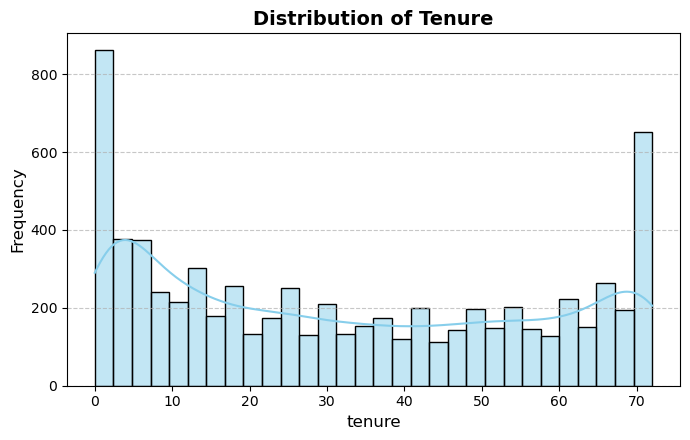

In [10]:
plot_numerical_distribution(data, 'tenure', 'Distribution of Tenure')

Observations
- A large number of customers are clustered at low tenure (close to 0 months) -> suggest a retention issue? 
- There’s also a noticeable peak at 72 month

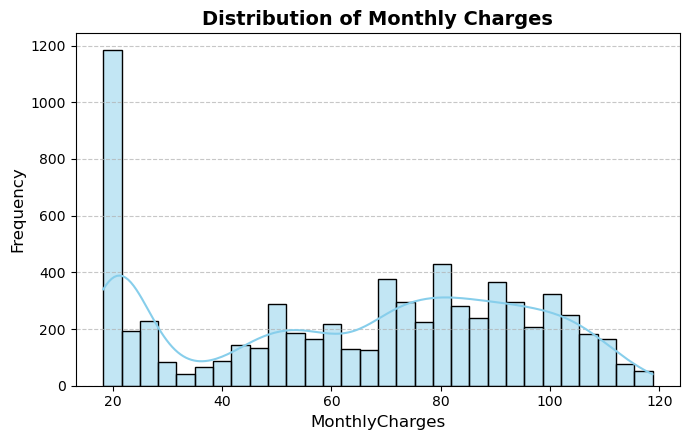

In [11]:
plot_numerical_distribution(data, column='MonthlyCharges', title='Distribution of Monthly Charges')

Observations
- Most customers pay between 20$ and 80$
- There may be small spikes at round numbers (e.g., $70, $100), suggesting tiered or bundled plans

Impacts
- Investigate whether high paying customer has more churn rate
- consider engineering spending tier feature

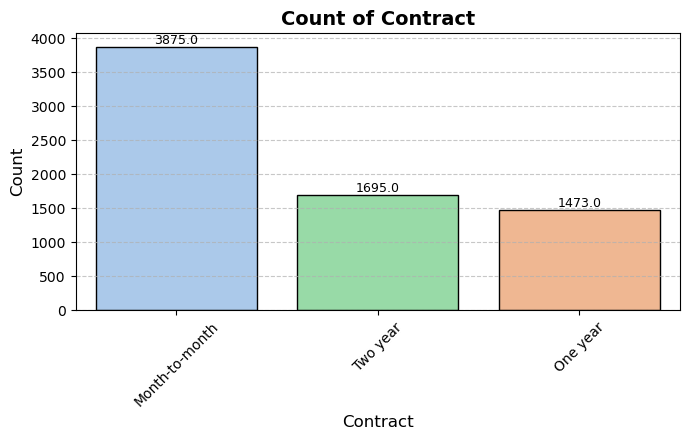

In [12]:
plot_categorical_distribution(data, column='Contract', show_labels=True)

Observations
- Most customers are on **month-to-month** contracts, followed by one- and two-year plans.  
- Month-to-month contracts may suggest higher churn potential due to flexibility.

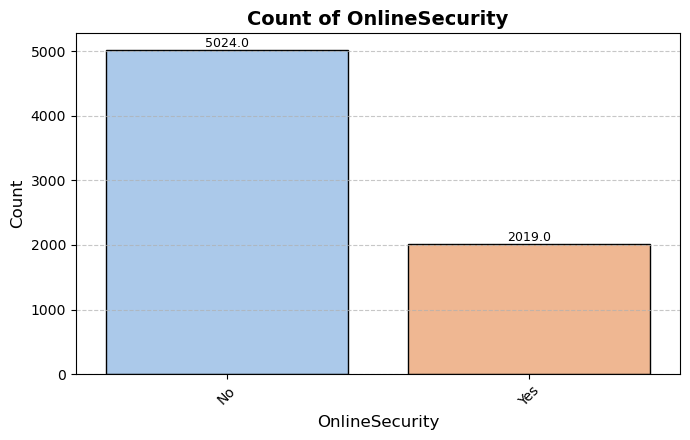

In [13]:
plot_categorical_distribution(data, column='OnlineSecurity', show_labels=True)

Observation
- A significant number of customers do **not** have online security services.  

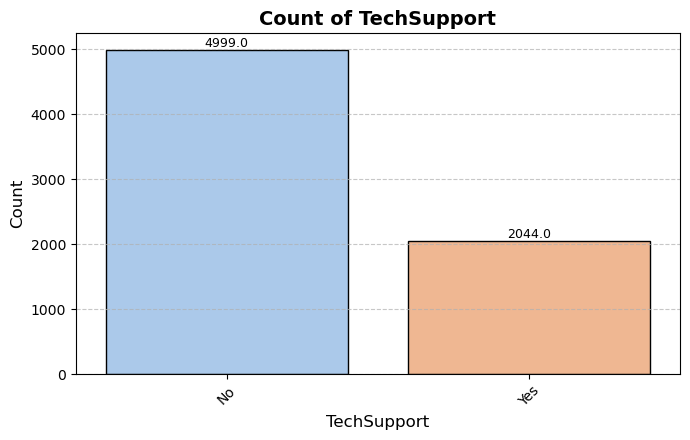

In [14]:
plot_categorical_distribution(data, column='TechSupport', show_labels=True)

Observation
- most customers do **not** use technical support -> This might reflect either self-reliance or dissatisfaction with the service

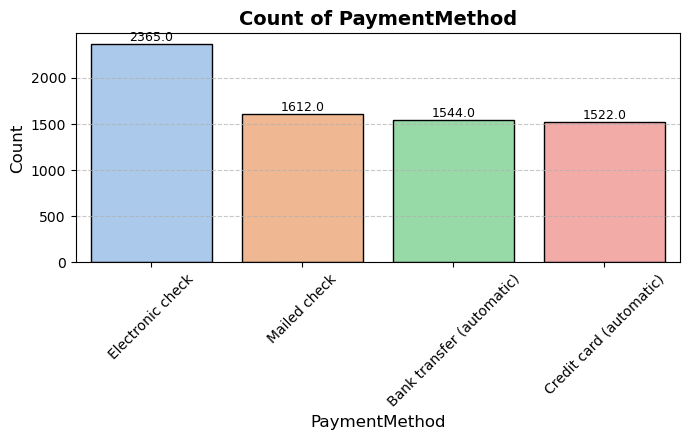

In [15]:
plot_categorical_distribution(data, column='PaymentMethod', show_labels=True)

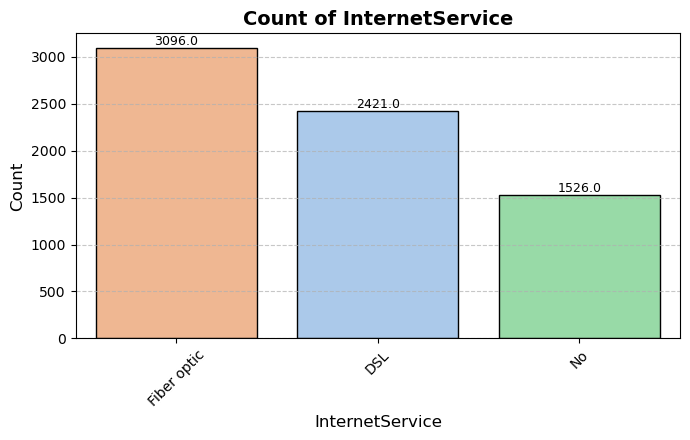

In [16]:
plot_categorical_distribution(data, column='InternetService', show_labels=True)

Observations
- Majority of customers have **Fiber optic** internet, followed by DSL and None.  
- Fiber optic users may show different churn patterns due to higher expectations.

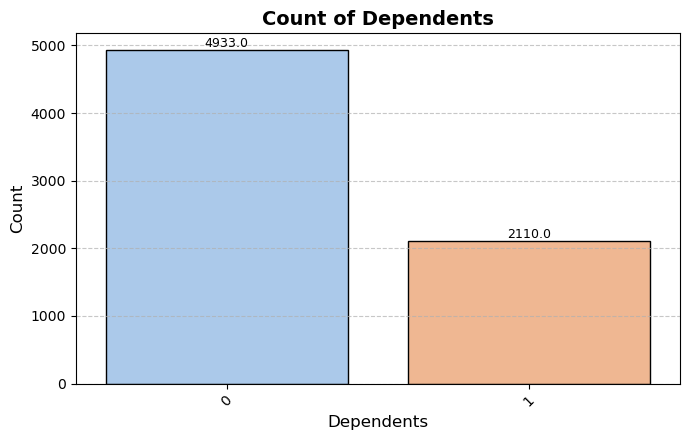

In [17]:
plot_categorical_distribution(data, column='Dependents', show_labels=True)

## Bivariate Analysis (Feature vs Target)

### Hypothesis
Month-to-month contracts have higher churn than long-term contracts because it is easier to leave with no commitment

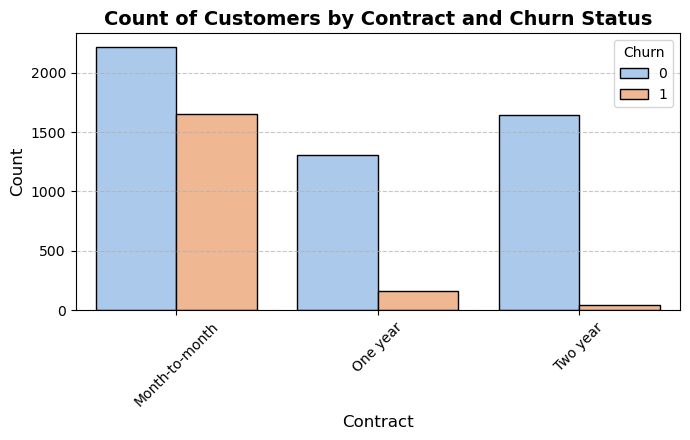

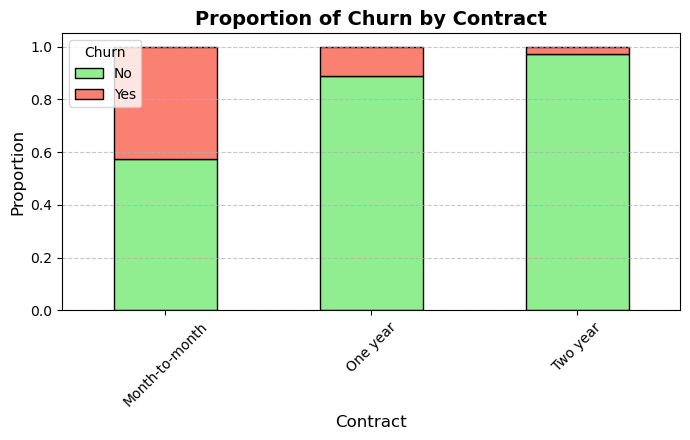

In [18]:
countplot_with_churn(data, column='Contract')
stacked_bar_churn_ratio(data, column='Contract')

Observations
- Among the three contract types, `Month-to-month` users have the highest churn rate.
- They also make up the majority of the customer base, amplifying their impact on overall churn

short term contract create lower retention -> Retention strategies target this segment could help reduce churn in this segment

### Hypothesis
Customers without tech support are more likely to churn

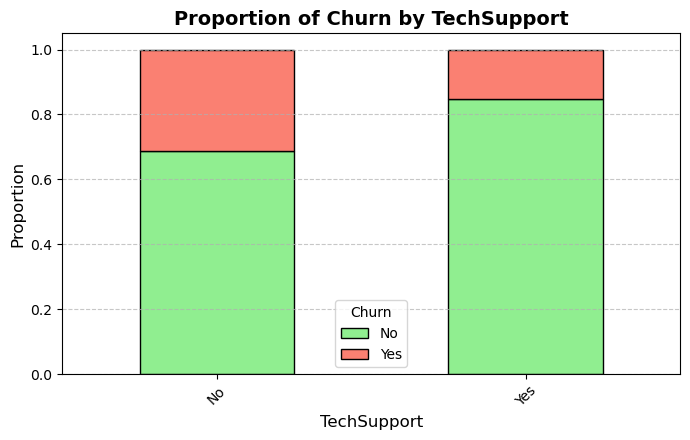

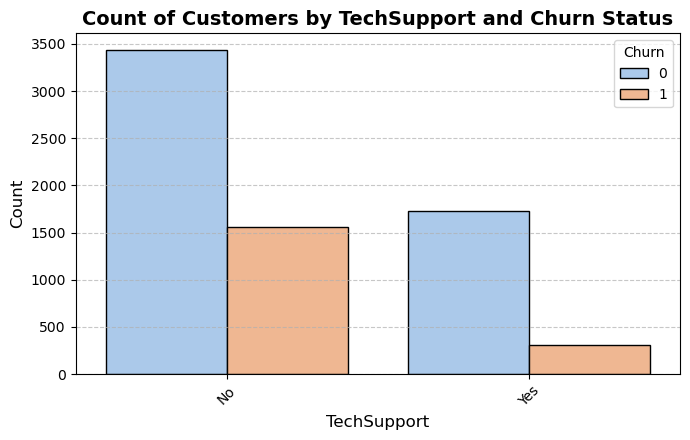

In [41]:
stacked_bar_churn_ratio(data, column='TechSupport')
countplot_with_churn(data, 'TechSupport')

Observations
- customers **without Tech Support** churn at much higher rates compared to those with support
- This suggests that offering or promoting Tech Support services could be an effective **retention strategy**

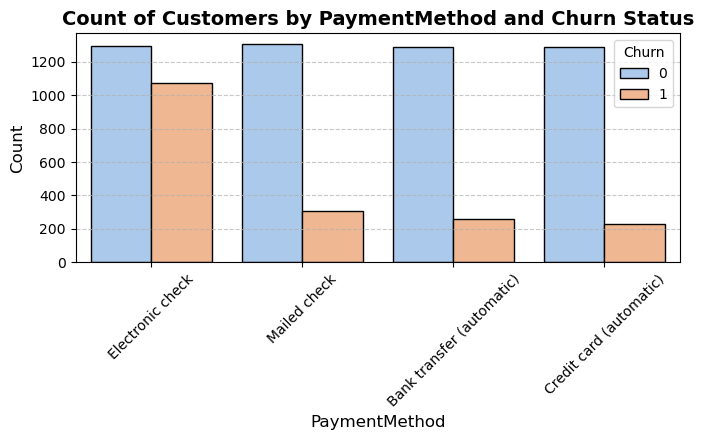

In [20]:
countplot_with_churn(data, column='PaymentMethod')

Observations
- **Electronic check** users show the **highest churn rate** among all payment methods.
- This may indicate a correlation between **payment flexibility or perceived hassle** and customer retention

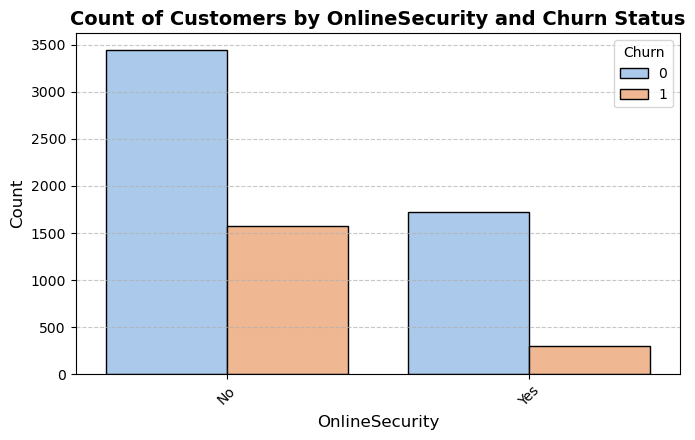

In [21]:
countplot_with_churn(data, column='OnlineSecurity')

Observation
- Customers who do not have Online Security have a significantly higher churn rate compared to those who have it (Yes) or those with No internet service

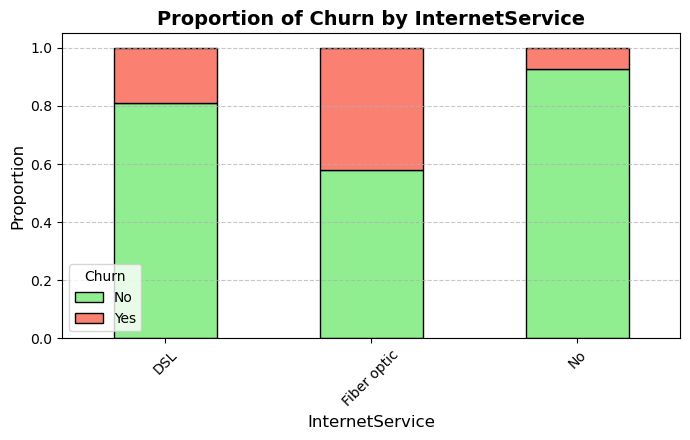

In [22]:
stacked_bar_churn_ratio(data, column='InternetService')

Observation
- Fiber optic users have the highest churn proportion, with almost half of them churning
- Customers with no internet service have the lowest churn rate,these customers may have minimal engagement with the service

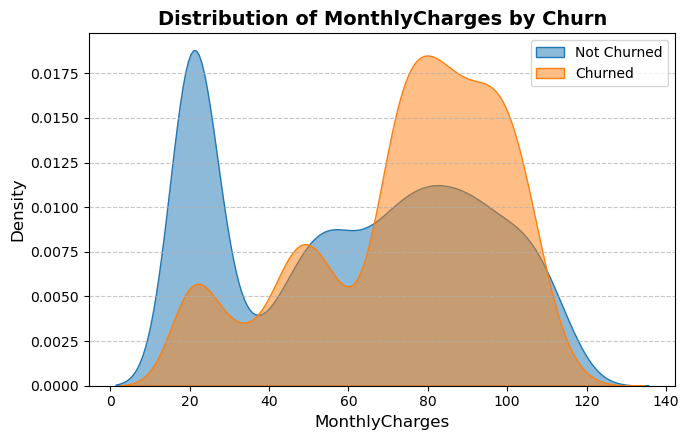

In [23]:
kdeplot_by_churn(data, column='MonthlyCharges')

Observations
- Churn is higher in customers with moderately high monthly charges (e.g., $70–$100). Low-charge customers tend to churn less

#### Hypothesis
Customers with shorter tenure are more likely to churn as new customers may still be evaluating the service

/Users/mewpunyapat/Customer_chern_prediction/utils/visuals.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y=column, palette='Set2')


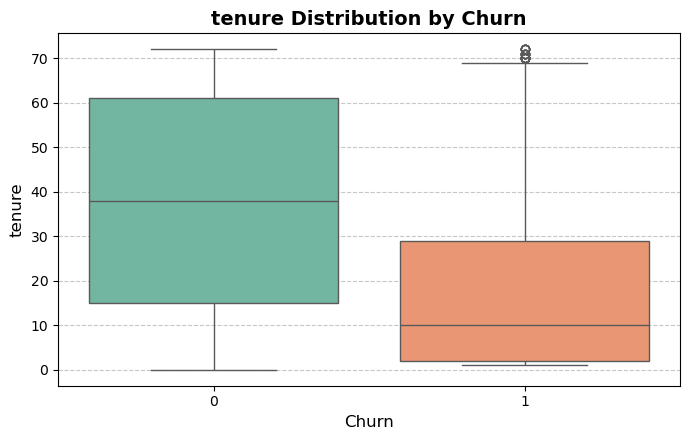

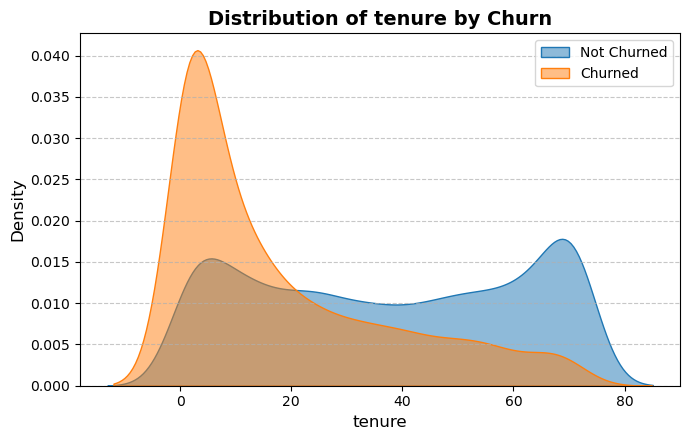

In [24]:
boxplot_by_churn(data, column='tenure')
kdeplot_by_churn(data, column='tenure')

Churn rate is significantly higher among customers with shorter tenure. The median tenure for churned users is much lower than for retained users -> Customers in their early months are more at risk

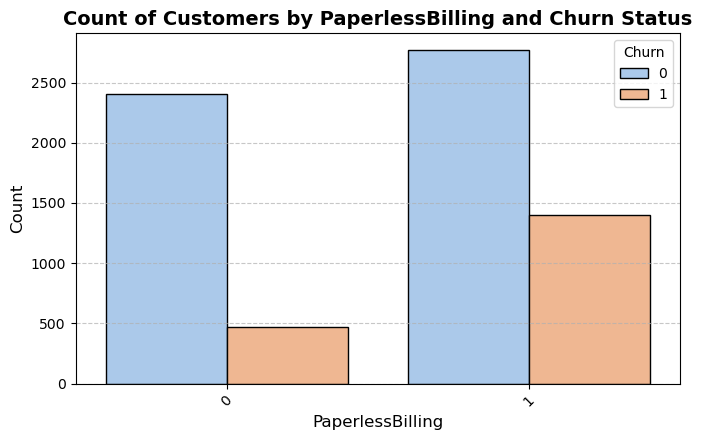

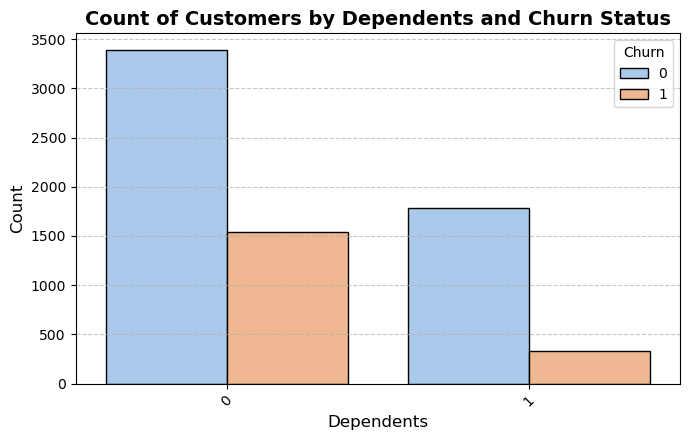

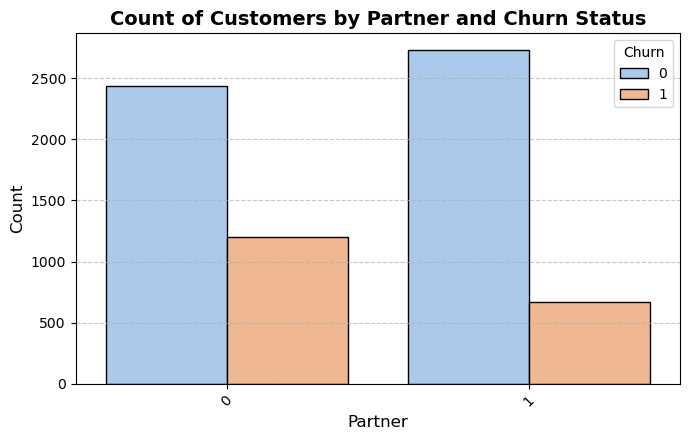

In [25]:
countplot_with_churn(data, column='PaperlessBilling')
countplot_with_churn(data, column='Dependents')
countplot_with_churn(data, column='Partner')

Observations
- A larger proportion of churned users use paperless billing compared to non-churners
- Customers with dependents churn significantly less than those without

## Multivariate Analysis

#### Hypothesis
Customers with low tenure and high monthly charges are more likely to churn

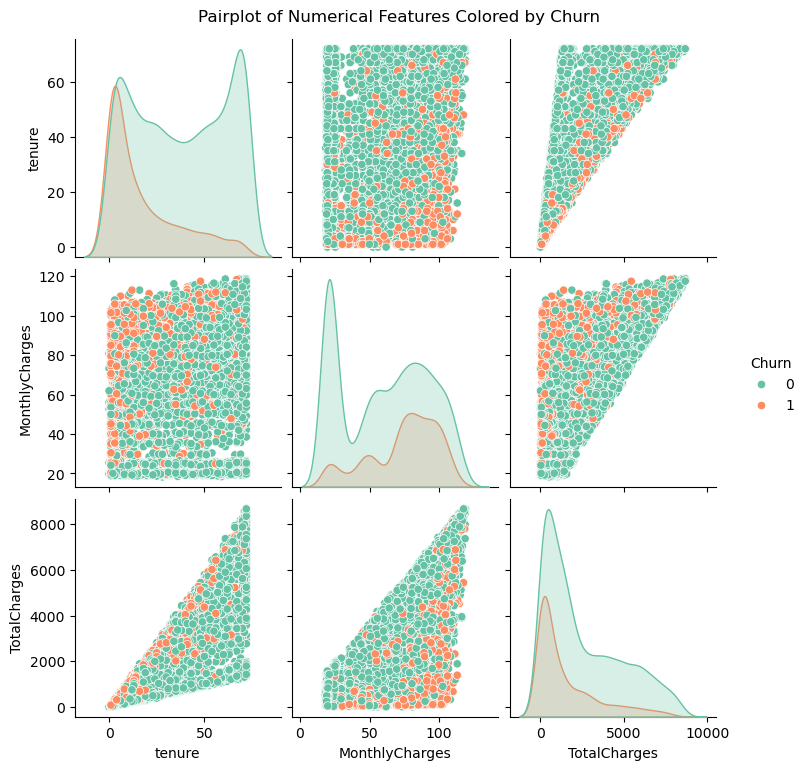

In [26]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
sns.pairplot(data, vars=numerical_cols, hue='Churn', palette='Set2')
plt.suptitle("Pairplot of Numerical Features Colored by Churn", y=1.02)
plt.show()

Observations:
1. Customers with short tenure and high monthly charges tend to churn more
2. A strong positive linear relationship between `tenure` and `TotalChargesis` is observed. Churners cluster more around low tenure and low total charges
3. Churners are often located in the high monthly charge but low total charge region

Business implications:
The company should target new customer paying high fee as these are where most customer churn, indicating that the customer may get dissatisfied or feel like the money spent is not worthy. early-stage retention strategies need to be prioritized to solve this issue

### Contract x Payment

#### Hypothesis 
Does effort and commitment affect churn rate?

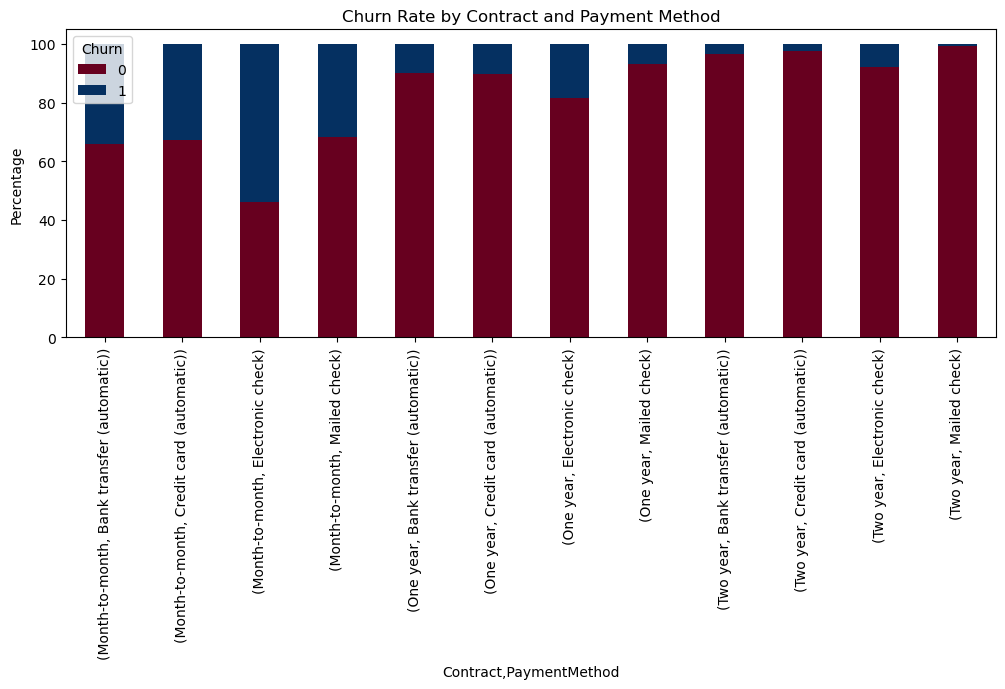

In [27]:
pivot = pd.crosstab([data['Contract'], data['PaymentMethod']], data['Churn'], normalize='index') * 100
pivot.plot(kind='bar', stacked=True, figsize=(12,4), colormap='RdBu')
plt.title('Churn Rate by Contract and Payment Method')
plt.ylabel('Percentage')
plt.show()


Observations
- Month-to-month contracts show the highest churn rates across all payment methods:
    - Especially high for Electronic Check users (around 50% churn).
    - Lower churn for automatic payments (Bank transfer, Credit card) but still significant.

- One-year and Two-year contracts significantly reduce churn:
    - Two-year contracts have very low churn, nearly 0–5% across all payment types.
    - One-year contracts also show strong retention, especially with automatic payments.
- Electronic Check payments consistently associate with higher churn
- Automatic payments (bank transfer or credit card) correlate with lower churn rates, regardless of contract length.

Insights
- Auto-payment setups reduce churn because they require minimal effort, it is essential to target Electronic Check users (highest proportion) to switch to this 
- Contract length is a strong retention lever -> Long-term commitment lead to lower churn rate

### Internet Service vs Tech Support vs Churn
#### Hypothesis
Among customers with internet service, those who do not have tech support will exhibit higher churn rates than those who do.

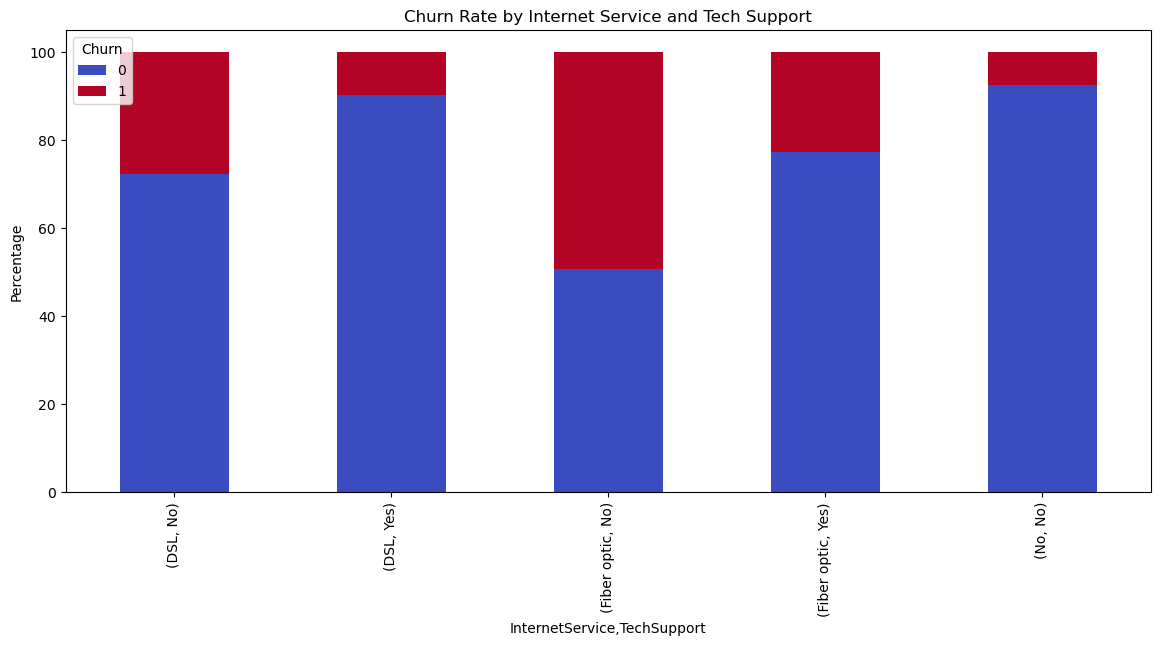

In [28]:
pivot = pd.crosstab([data['InternetService'], data['TechSupport']], data['Churn'], normalize='index') * 100
pivot.plot(kind='bar', stacked=True, figsize=(14,6), colormap='coolwarm')
plt.title('Churn Rate by Internet Service and Tech Support')
plt.ylabel('Percentage')
plt.show()


Insights
- The presence of `TechSupport` significantly lower churn rate across all `InternetService` type, indicating its importance in customer retention
- Fiber optic services exhibit higher churn rates compared to DSL when tech support is unavailable, possibly due to higher expectations or complexity.
- Regardless of having technical support, no internet service has negligible churn, supporting the fact that churn is primarily linked to service quality and support rather than other factors

### Contract vs InternetService

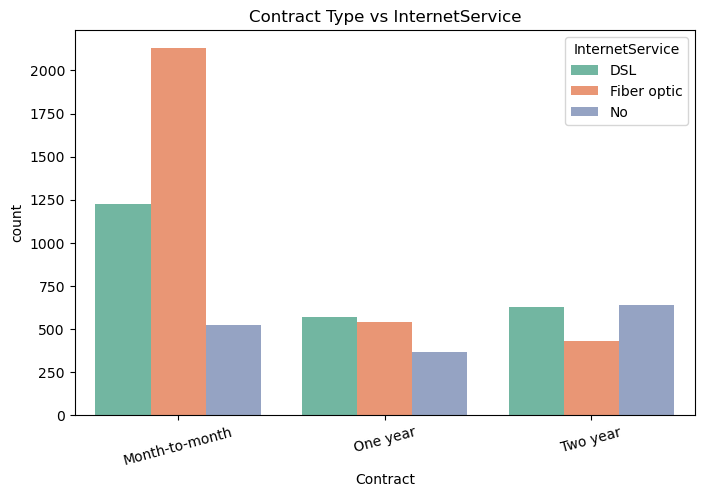

In [29]:
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='Contract', hue='InternetService', palette='Set2')
plt.title('Contract Type vs InternetService')
plt.xticks(rotation=15)
plt.show()


Observations
- Month-to-month customer mostly use Fiber optic
- The preference for fiber optic drops significantly with longer contract terms, while DSL remains relatively consistent across all contract types

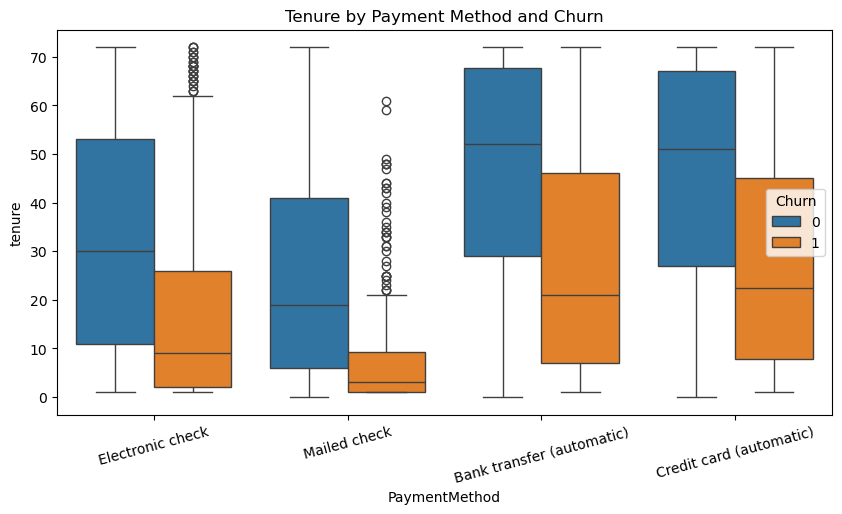

In [30]:
plt.figure(figsize=(10,5))
sns.boxplot(data=data, x='PaymentMethod', y='tenure', hue='Churn')
plt.title('Tenure by Payment Method and Churn')
plt.xticks(rotation=15)
plt.show()


Insights
- Automatic payment methods (bank transfer and credit card) are associated with longer median tenures and lower churn rates compared to manual methods (electronic and mailed checks).
- Mailed check shows the lowest churn tenure, suggesting it may retain customers with shorter tenures effectively.
- Electronic check has a higher churn rate at lower tenures, indicating potential dissatisfaction or instability among these customers

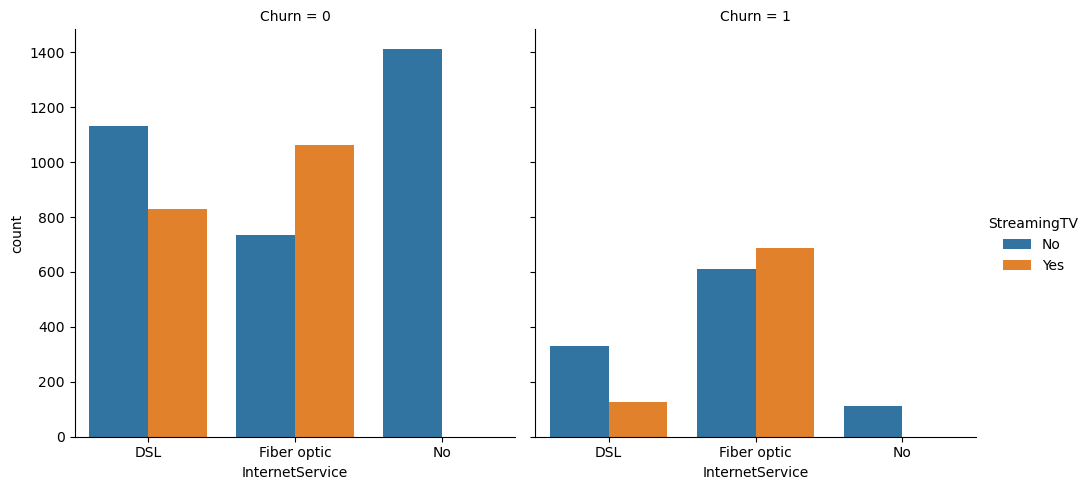

In [31]:
sns.catplot(data=data, x="InternetService", hue="StreamingTV", col="Churn", kind="count")


Insights
- Customers with fiber optic service and StreamingTV have the highest churn rate (700), suggesting a potential correlation between these add-ons and dissatisfaction.
- DSL customers show lower churn rates overall, with or without StreamingTV, indicating greater stability.
- The absence of internet service correlates with almost no churn, regardless of StreamingTV, highlighting that churn is tied to active service usage.
- StreamingTV seems to increase churn, especially with fiber optic, possibly due to additional costs or service issues

## Summary

The exploratory data analysis reveals several key factors influencing customer churn:
- **Key Insights**:
    Churn Factors can be classified under three themes:
    1. Retention Risk (New Users & Contract Type)
        - Shorter tenures, higher monthly charges, and month-to-month contracts are strongly associated with churn 
        - Customers on month-to-month contracts have a churn rate of 42%, compared to 11% for two-year contracts.
        - Customers who pay 70-100 per month has greater chance of churn
    - Recommendation: The company should focus on new user segments, this can be done via monitoring satisfaction or offering incentives to them
    2. Convenience & Trust (Payment & Support)
        - Automatic payment methods and availability of tech support/online security reduce churn likelihood
    - Insight: Frictionless payment and reliable support enhance retention
    3. Perceived Value
        - Fiber optic customers with StreamingTV exhibit the highest churn, possibly due to service or cost issues
        - over 40% of customer who use fiber optic service churn, this type of service also the most chosen among month-to-month contract type, supporting earlier insight
    - Possible reason: Customer may feel dissatisfied with quality of service and underwhelming

### Implications for Modelling
- Short Tenure, Month-to-Month Contracts, and High Charges Are Strong Churn Indicators -> Bucket tenure into bins
- Consider crafting lifecycle-related features
- categorical variables must be encoded properly
- Churn is imbalanced -> use stratified train-test split